# Fairness in Modelling

Fairness is defined to be, “the quality of treating people equally or in a way that is right or reasonable”, in the Cambridge English Dictionary. In the context of Fairness in classification tasks, this means that any decision or outcome predicted from a modelling tool must prevent discrimination against protected population subgroups. To begin to do this, it is first of all important to examine the input data, extract binary protected groups and view it under the lenses of Bias Detection. Once, we are ready to model, we must build the baseline model and consider additional techniques that instill fairness into the algortihm.

## Initial Data Bias Detection

First, define the favourable and unfavourable outcome of their modelling problem and select the protected classes present in their dataset. A protected group or class $\mathbf{S}$ is a category by which people are qualified for special protection by a law, policy, or similar authority. Then identify the **Advantegous or Privileged subset** $\mathbf{S}_{a}$ and the **Disadvantegous or Unprivileged subset** $\mathbf{S}_{d}$ within each protected group. In this context, $S_a$, the advantageous group of a protected attribute (S) that is typically shown to have a higher probability of getting a favourable outcome while $S_d$, the disadvantageous group shows a lower probability of having a favourable outcome. In order to choose the appropriate advantageous and disadvantageous subsets it is useful to plot heatmaps of the frequency of each of the protected groups by target label.

<p class='lead'> Key Definitions: </p>

- **Protected group** is a feature $\mathbf{S}$ that belongs to our input features $\mathbf{X}$
- **Advantageous group / Privileged** is a level $\mathbf{S}_{a}$ of the feature $\mathbf{S}$ having a higher probability of favourable outcome.
- **Disadvantageous group / Unprivileged** is a level $\mathbf{S}_{d}$ of the feature  $\mathbf{S}$ having lower probability of favourable outcome.
- **Actual labels / target** is a categorical variable represented by $\mathbf{Y}$ 
- **Predicted labels** are represented $\hat{Y}$
- *For the mathematical equations the **favourable outcome** is defined to be $\hat{Y} = 1$.*

## Causal Reasoning 

Fairness definitions based on causal reasoning stem from a given causal graph: a directed, acyclic graphs with nodes representing attributes of an applicant and edges representing relationships between the attributes. Such a graph can help build a fair classifier as it  maps the relations between attributes and their influence on the outcome by a set of structural equations. These equations can further be used to estimate the effects of sensitive attributes and build algorithms that ensure a tolerable level of discrimination due to these attributes.

Consider a graph consisting of the protected attribute $\mathbf{S}$ (Gender), other non-protected attributes such credit amount,  credit history and employment length and finally a predicted outcome $\mathbf{\hat{Y}}$ (defaulter vs non-defaulter). In causal graphs, a *proxy* attribute is an attribute whose value can be used to derive a value of another attribute. In our example, we assume that employment length acts as a proxy attribute for G: one can derive the applicants’ gender from the length of their employment.

<!-- A resolving attribute is an attribute in the causal graph that is influenced by the protected attribute in a non-discriminatory manner. In our example, the effect of G on the credit amount is non- discriminatory, which means that the differences in credit amount for different values of G are not considered as discrimination. Hence, the credit amount acts as a resolving attribute for G in this graph. -->

**Counterfactual fairness**: A causal graph is counter-factually fair if the predicted outcome $\mathbf{\hat{Y}}$ in the graph does not depend on a descendant of the protected attribute $\mathbf{S}$. In our example, the predictive outcome $\mathbf{\hat{Y}}$ of defaulter vs non-defaulter for a loan application is dependent on credit history, credit amount, and employment length. If employment length is a direct descendant of $\mathbf{S}$, the given causal model is not counterfactually fair.

To be fair, the protected attribute $\mathbf{S}$ should not be a cause of $\mathbf{\hat{Y}}$ in any individual instance. That is changing $\mathbf{S}$ while holding attributes which are not causally dependent on $\mathbf{S}$ constant should not change the distribution of $\mathbf{\hat{Y}}$. $\mathbf{\hat{Y}}$ will be counterfactually
fair if it is a function of the non-descendants of $\mathbf{S}$.

One way to remove these causal dependencies are through explicitly modelling all input variables as a linear combination of the protected class variables. By taking the residuals as a difference between actual and predicted input variables ($X-\hat{X}$) we can effectively remove the correlation between the protected classes to the input variables. 

## Additive counterfactual fair model 

The implementation of a [**linear counterfactually fair**](https://arxiv.org/pdf/1703.06856.pdf) model uses the each of the protected class variable ($\mathbf{S}$) to compute the residuals for each input variable ($\mathbf{X}$) and then calculate the residuals as a difference between actual and predicted values ($\mathbf{X}-\hat{X}$) which is then used to learn a function that maps from inputs to the target variable ($\mathbf{Y}$). 

ACF,within the framework of counterfactual fairness, is the idea that we model the correlations between  ${S}$  and features in  ${X}$  by training linear models to predict each feature  ${X_j}$  using  ${S}$  as input.

Then, we can compute the residuals  ${ϵ_{ij}}$  between predicted and true feature values for each observation  ${i}$  and feature  ${j}$ . The final model is then trained on  ${ϵ_{ij}}$  as features to predict  ($\mathbf{Y}$).


$$
\begin{array}{c}
{X_{1}=\beta_{0}+\beta_{1} S_{1}+\beta_{2} S_{2}+\cdots+\beta_{n} S_{n}+\epsilon_{1}} \\ {X_{n}=\beta_{0}+\beta_{1} S_{1}+\beta_{2} S_{2}+\cdots+\beta_{n} S_{n}+\epsilon_{n}} \\ {\epsilon_{X1}={X_{1}}-\hat{X_{1}}\left(S_{1}, S_{2}, \ldots, S_{n}\right)} \\ {\epsilon_{Xn}={X_{n}}-\hat{X_{n}}\left(S_{1}, S_{2}, \ldots, S_{n}\right)} \\ 
\end{array}
$$

$$
{Y=\frac{e^{\beta_{0}+\beta_{1} \epsilon_{X1}+\cdots+\beta_{n} \epsilon_{Xn}}}{1+e^{\beta_{0}+\beta_{1} \epsilon_{X1}+\cdots+\beta_{n} \epsilon_{Xn}}}}
$$

<p class='lead'> Code Example using the LoanEE2 Dataset: </p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import inf
from scipy.stats import kurtosis, skew

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import average_precision_score

from fair_metrics import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('ProtectedFeaturesLoanEE2.csv')

#### Select favourable and unfavourable outcome

In [3]:
target='Default'

fav=0
unfav=int(not fav)

#### Identify the protected groups and the respective advantageous and disadvantageous subsets

In [4]:
Male='Gender' #Male/Female (originally work ex less than 10)
Young='Age' #Young/Old
National='Nationality' #Foreign/National
Married='Married' 
Single='Single'
Divorced='Divorced' 
Disabled='Disability' #(originally no of dep <3)

In [5]:
protected_groups=[Male, Young, National, Married, Single, Divorced, Disabled]

In [6]:
adv_groups = [{Male :1}, {Young :0}, {National :1}, {Married :0}, {Single :0}, {Divorced :1}, {Disabled :1}]
disadv_groups = [{Male :0}, {Young :1}, {National :0}, {Married :1}, {Single :1}, {Divorced :0}, {Disabled :0}]

In [7]:
SP=[]
DI=[]
Protected=[]
for groupe in range(0, len(protected_groups)):
    protected_group = list(adv_groups[groupe].keys())[0]
    adv_protected_group_value = adv_groups[groupe][protected_group]
    disadv_protected_group_value = disadv_groups[groupe][protected_group]
    statistical_parity, disparate_impact = statistical_parity_test(data, protected_group,
              adv_protected_group_value, disadv_protected_group_value, target, fav)
    
    SP.append(statistical_parity)
    DI.append(disparate_impact)
    Protected.append(protected_group)

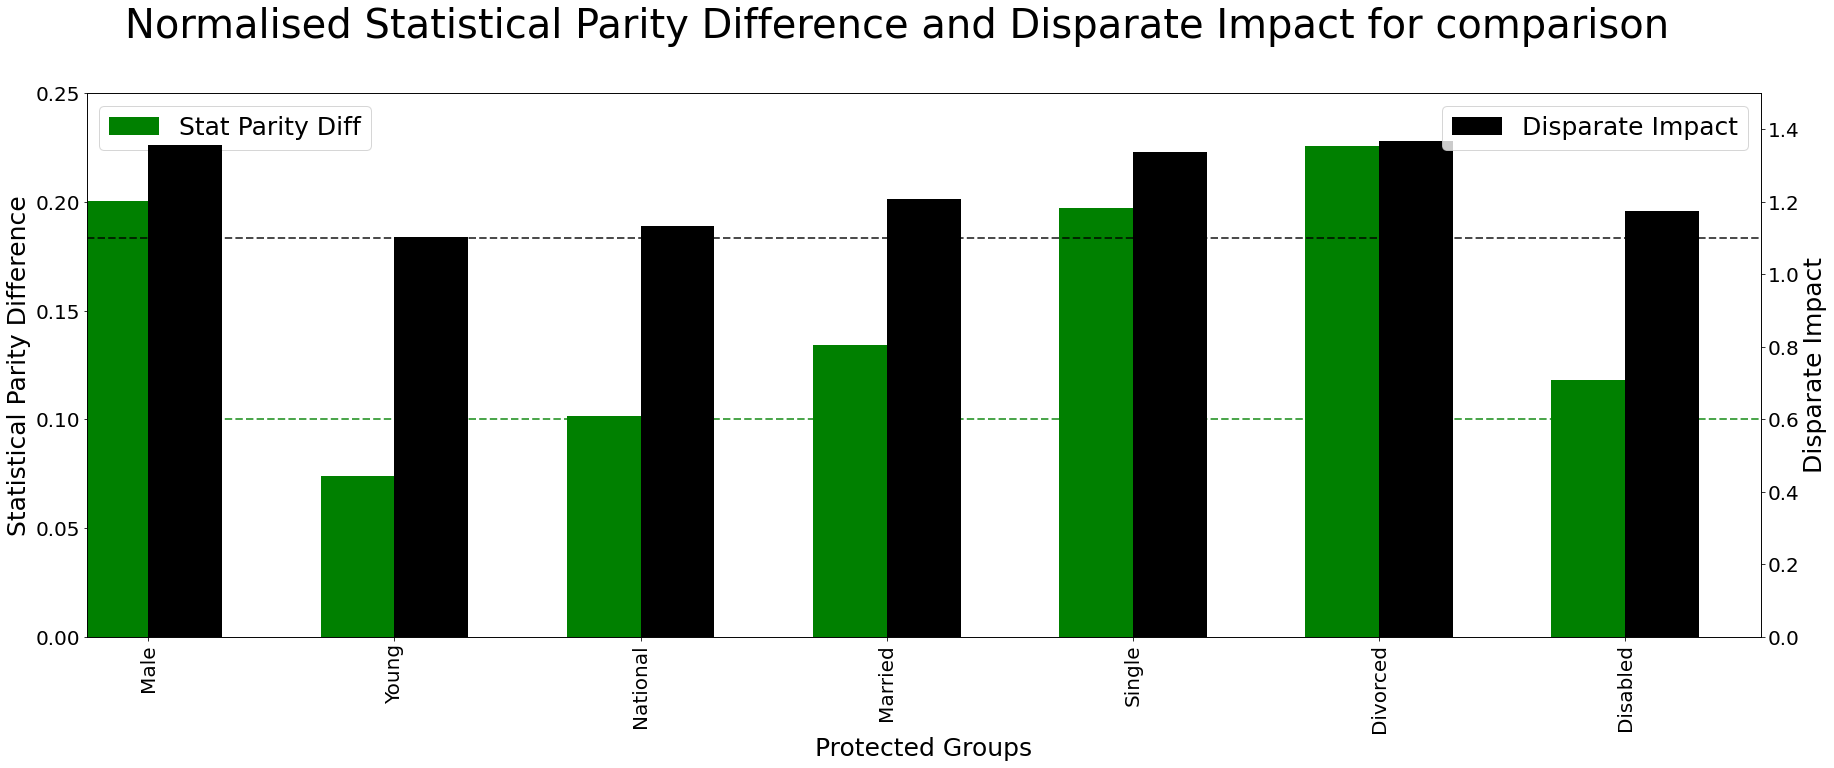

In [8]:
d = pd.DataFrame({'Protected_feature':Protected,'Statistical_Parity':SP,'Disparate_Impact':DI})
d['DI_normal']=d["Disparate_Impact"].apply(lambda x: 1/x if x < 1 else x)
d['SP_normal']=d["Statistical_Parity"].apply(lambda x: abs(x) if x < 0 else x)

fig = plt.figure() 
ax = fig.add_subplot(111) 
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

fig.suptitle('Normalised Statistical Parity Difference and Disparate Impact for comparison', fontsize=40, y=1)

width = 0.3
ax.set_ylim(0, 0.25) 
ax2.set_ylim(0, 1.5) 

d.plot(x ='Protected_feature', y='SP_normal', kind = 'bar', ax=ax, width=width, 
       position=1, color='green', legend=False, figsize=(30,10), fontsize=20)
d.plot(x ='Protected_feature', y='DI_normal', kind = 'bar', ax=ax2, width=width, 
       position=0, color='black', legend=False, figsize=(30,10), fontsize=20)

ax.axhline(y=0.1, linestyle='dashed', linewidth=2, alpha=0.7, color='green')
ax2.axhline(y=1.10, linestyle='dashed', linewidth=2, alpha=0.7, color='black')

patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['Stat Parity Diff'], loc='upper left', fontsize=25)

patches, labels = ax2.get_legend_handles_labels()
ax2.legend(patches, ['Disparate Impact'], loc='upper right', fontsize=25)

labels = [item.get_text() for item in ax.get_xticklabels()]

labels[0] = 'Male'
labels[1] = 'Young'
labels[2] = 'National'
labels[3] = 'Married'
labels[4] = 'Single'
labels[5] = 'Divorced'
labels[6] = 'Disabled'

ax.set_xticklabels(labels)
ax.set_xlabel('Protected Groups', fontsize=25)
ax.set_ylabel('Statistical Parity Difference', fontsize=25)
ax2.set_ylabel('Disparate Impact', fontsize=25)

plt.show()

<div class="alert alert-block alert-warning">
<b>Remember:</b>
    
- Here the target variable is:
 - Default
- The independent variables are:
 - Age
 - AppliedAmount
 - ExpectedLoss
 - LiabilitiesTotal
 - IncomeTotal
 - Interest
 - LoanDuration
 - MonthlyPayment
- The sensitive variables are:
 - Male
 - Married
 - Single
 - Divorced
 - Disabled
</div>

#### Fill in missing values

In [9]:
data['MonthlyPayment'].fillna((data['MonthlyPayment'].mean()), inplace=True)
data['ExpectedLoss'].fillna((data['ExpectedLoss'].mean()), inplace=True)
data['ProbabilityOfDefault'].fillna((data['ProbabilityOfDefault'].mean()), inplace=True)
data['DebtToIncome'].fillna((data['DebtToIncome'].mean()), inplace=True)
data['FreeCash'].fillna((data['FreeCash'].mean()), inplace=True)
data['LossGivenDefault'].fillna(0, inplace=True)

In [10]:
dataacf = data[['Default','Age', 'AppliedAmount', 'ExpectedLoss', 'LiabilitiesTotal', 'IncomeTotal', 
                'Interest', 'LoanDuration', 'MonthlyPayment', Male, Married, Single, Divorced, Disabled]]

In [11]:
biased_protected_groups = [Male, Married, Single, Divorced, Disabled]

In [12]:
choice = Male

## Baseline model : Logistic Regression

In [13]:
y=dataacf['Default']
x=dataacf.drop(columns=['Default'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=6666)

In [14]:
log_reg = LogisticRegression(random_state=0, solver='liblinear',
                              multi_class='ovr').fit(X_train, y_train)

In [15]:
y_pred=log_reg.predict(X_test)
y_pred_prob=log_reg.predict_proba(X_test)[:,0]
print("Accuracy of the baseline model:", log_reg.score(X_test, y_test))

Accuracy of the baseline model: 0.7746432939258051


In [16]:
A_full=log_reg.score(X_test[X_test[choice]==0], y_test[X_test[choice]==0]) 
B_full=log_reg.score(X_test[X_test[choice]==1], y_test[X_test[choice]==1]) 
print("Accuracy difference between two groups:", abs(B_full-A_full)*100, "%")

Accuracy difference between two groups: 7.646828821054896 %


## Additive counterfactual fair model by hand


In [17]:
y=dataacf['Default']
x=dataacf.drop(columns=['Default'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=6666)

In [18]:
sens=X_train[biased_protected_groups]

#### Regressing each independant variable with sensitive variable

In [19]:
acf_age = LinearRegression().fit(sens, X_train['Age'])
acf_AppliedAmount = LinearRegression().fit(sens, X_train['AppliedAmount'])
acf_ExpectedLoss = LinearRegression().fit(sens, X_train['ExpectedLoss'])
acf_LiabilitiesTotal = LinearRegression().fit(sens, X_train['LiabilitiesTotal'])
acf_IncomeTotal = LinearRegression().fit(sens, X_train['IncomeTotal'])
acf_Interest = LinearRegression().fit(sens, X_train['Interest'])
acf_LoanDuration = LinearRegression().fit(sens, X_train['LoanDuration'])
acf_MonthlyPayment = LinearRegression().fit(sens, X_train['MonthlyPayment'])

#### Calculate the residuals for each model

In [20]:
ageR = X_train['Age'] - acf_age.predict(sens)
AppliedAmountR = X_train['AppliedAmount'] - acf_AppliedAmount.predict(sens)
ExpectedLossR = X_train['ExpectedLoss'] - acf_ExpectedLoss.predict(sens)
LiabilitiesTotalR = X_train['LiabilitiesTotal'] - acf_LiabilitiesTotal.predict(sens)
IncomeTotalR = X_train['IncomeTotal'] - acf_IncomeTotal.predict(sens)
InterestR = X_train['Interest'] - acf_Interest.predict(sens)
LoanDurationR = X_train['LoanDuration'] - acf_LoanDuration.predict(sens)
MonthlyPaymentR = X_train['MonthlyPayment'] - acf_MonthlyPayment.predict(sens)

In [21]:
df_R=pd.DataFrame({'ageR':ageR, 'AppliedAmountR':AppliedAmountR, 'ExpectedLossR':ExpectedLossR, 
                   'LiabilitiesTotalR':LiabilitiesTotalR,
                'IncomeTotalR':IncomeTotalR, 'InterestR':InterestR, 'LoanDurationR':LoanDurationR,
                   'MonthlyPaymentR':MonthlyPaymentR})

In [22]:
df_R

,ageR,AppliedAmountR,ExpectedLossR,LiabilitiesTotalR,IncomeTotalR,InterestR,LoanDurationR,MonthlyPaymentR
38757,-0.321170,-1068.321959,0.005515,-333.155688,-836.347136,0.507569,-3.188312,-30.807247
19905,-0.396304,-1385.505095,-0.064279,-97.595945,-460.928661,-12.422890,14.053032,-63.505812
24584,0.603696,-110.505095,-0.040479,65.604055,511.071339,-8.132890,14.053032,-27.085812
8420,0.678830,-1658.321959,0.072676,1176.844312,907.652864,8.597569,-36.188312,-9.748320
4015,0.207263,614.721028,-0.065619,-378.915280,-1358.049074,0.836386,-2.754943,-3.655850
...,...,...,...,...,...,...,...,...
2150,-0.321170,-2338.763759,-0.008035,-693.155688,9463.652864,4.597569,-27.188312,-9.748320
53913,0.603696,-1705.505095,0.000421,8.554055,-648.928661,3.097110,-9.946968,-61.505812
10335,0.829799,-2423.979577,0.001478,-242.128604,-1495.001221,0.899610,19.927358,-91.410417
36625,-0.396304,2544.494905,0.028222,-302.785945,-710.928661,7.677110,-9.946968,136.204188


#### Fitting residuals to the dependent (target) variable

In [23]:
fair = LogisticRegression(random_state=0, solver='liblinear',
                              multi_class='ovr').fit(df_R, y_train)

#### Calculate residuals for the test data

In [24]:
sens=X_test[biased_protected_groups]

In [25]:
ageR = X_test['Age'] - acf_age.predict(sens)
AppliedAmountR = X_test['AppliedAmount'] - acf_AppliedAmount.predict(sens)
ExpectedLossR = X_test['ExpectedLoss'] - acf_ExpectedLoss.predict(sens)
LiabilitiesTotalR = X_test['LiabilitiesTotal'] - acf_LiabilitiesTotal.predict(sens)
IncomeTotalR = X_test['IncomeTotal'] - acf_IncomeTotal.predict(sens)
InterestR = X_test['Interest'] - acf_Interest.predict(sens)
LoanDurationR = X_test['LoanDuration'] - acf_LoanDuration.predict(sens)
MonthlyPaymentR = X_test['MonthlyPayment'] - acf_MonthlyPayment.predict(sens)

In [26]:
df_R_test=pd.DataFrame({'ageR':ageR, 'AppliedAmountR':AppliedAmountR, 'ExpectedLossR':ExpectedLossR, 
                        'LiabilitiesTotalR':LiabilitiesTotalR,
                'IncomeTotalR':IncomeTotalR, 'InterestR':InterestR, 'LoanDurationR':LoanDurationR,
                   'MonthlyPaymentR':MonthlyPaymentR})

In [27]:
y_pred_fair = fair.predict(df_R_test)
y_pred_prob_fair = fair.predict_proba(df_R_test)

In [28]:
print("Accuracy of the fair model:", fair.score(df_R_test, y_test))

Accuracy of the fair model: 0.7666530778638402


In [29]:
A_full=fair.score(df_R_test[sens[choice]==0], y_test[sens[choice]==0]) 
B_full=fair.score(df_R_test[sens[choice]==1], y_test[sens[choice]==1]) 
print("Accuracy difference between two groups:", abs(B_full-A_full)*100, "%")

Accuracy difference between two groups: 26.13593463488296 %


In [30]:
tn_disadv, fp_disadv, fn_disadv, tp_disadv = confusion_matrix(y_test[sens[choice]==0], y_pred_fair[sens[choice]==0]).ravel()
tn_adv, fp_adv, fn_adv, tp_adv = confusion_matrix(y_test[sens[choice]==1], y_pred_fair[sens[choice]==1]).ravel()

acf_metrics = acf_fair_metrics(tn_disadv, fp_disadv, fn_disadv, tp_disadv, tn_adv, fp_adv, fn_adv, tp_adv)
acf_metrics

[('Equal Opps', 0.011220915330504289),
 ('PredEq', 0.002568218298555377),
 ('Equal Odds', 0.008652697031948993),
 ('PredParity', 0.34782608695652173),
 ('DemoParity', 0.008039181318088662),
 ('AOD', 0.004326348515974497),
 ('TEq', inf)]

## Additive Counterfactual Model using the class

In [31]:
independent_vars = ['Age', 'AppliedAmount', 'ExpectedLoss', 'LiabilitiesTotal', 'IncomeTotal', 
                    'Interest', 'LoanDuration', 'MonthlyPayment']
biased_protected_groups = [Male,Married,Single,Divorced,Disabled]

sens_train = X_train[biased_protected_groups]
sens_test = X_test[biased_protected_groups]

In [32]:
import ACF as acf_class

acf = acf_class.ACF(X_train, X_test, y_train, y_test, sens_train, sens_test, 
                    independent_vars)

main_model = LogisticRegression(random_state=0, 
                                solver='liblinear', 
                                multi_class='ovr')

acf_model = acf.fit(main_model)

In [33]:
y_pred_fair_class = acf.predict()

In [34]:
y_pred_prob_class = acf.predict_proba()

In [35]:
acf.score()

Accuracy of additive counterfactual fair model: 0.7666530778638402


0.7666530778638402

## Model Fairness Metrics

In [36]:
tn_disadv, fp_disadv, fn_disadv, tp_disadv = acf.confusion_mat(choice, 0)
tn_adv, fp_adv, fn_adv, tp_adv = acf.confusion_mat(choice, 1)

In [37]:
acf_metrics = acf_fair_metrics(tn_disadv, fp_disadv, fn_disadv, tp_disadv, tn_adv, fp_adv, fn_adv, tp_adv)
acf_metrics

[('Equal Opps', 0.011220915330504289),
 ('PredEq', 0.002568218298555377),
 ('Equal Odds', 0.008652697031948993),
 ('PredParity', 0.34782608695652173),
 ('DemoParity', 0.008039181318088662),
 ('AOD', 0.004326348515974497),
 ('TEq', inf)]

In [38]:
logistic_reg_fair_metrics = fair_metrics(y_test, y_pred_prob, y_pred, X_test, choice, 1, 0)
logistic_reg_fair_metrics

[('AUC', 0.09023602063466621),
 ('Avg PrecScore', 0.19863854302480735),
 ('Equal Opps', 0.48885028337083125),
 ('PredEq', 0.1930087390761548),
 ('Equal Odds', 0.681859022446986),
 ('PredParity', 0.16129032258064513),
 ('DemoParity', 0.3712618649552367),
 ('AOD', 0.340929511223493),
 ('TEq', 7.293956043956044)]

In [39]:
labels, log_reg_model = zip(*logistic_reg_fair_metrics)
headers, acf_model = zip(*acf_metrics)
ACF={'Metrics':headers[0:6], 
             'Baseline Model':list(log_reg_model[2:8]), 'ACF Fair Model':list(acf_model[0:6])}
ACF_table=pd.DataFrame.from_dict(ACF)
ACF_table

,Metrics,Baseline Model,ACF Fair Model
0,Equal Opps,0.488850,0.011221
1,PredEq,0.193009,0.002568
2,Equal Odds,0.681859,0.008653
3,PredParity,0.161290,0.347826
4,DemoParity,0.371262,0.008039
5,AOD,0.340930,0.004326


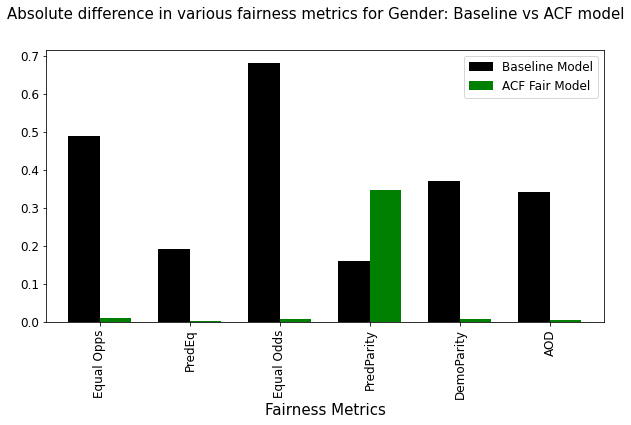

In [40]:
ax = ACF_table.plot.bar(x='Metrics', rot=90, width = 0.7, color=['black', 'green'], figsize=(10,5), fontsize=12)
plt.suptitle('Absolute difference in various fairness metrics for {}: Baseline vs ACF model'.format(choice),  
             fontsize=15, y=1)

patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper right', fontsize=12)

ax.set_xlabel('Fairness Metrics', fontsize=15)
plt.show()

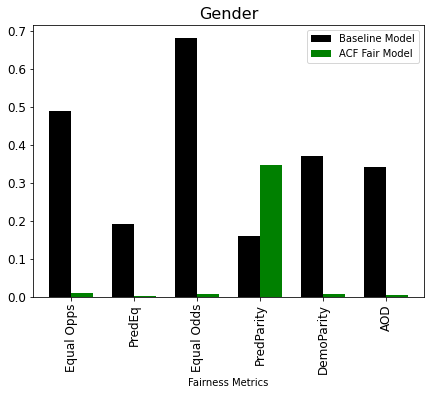

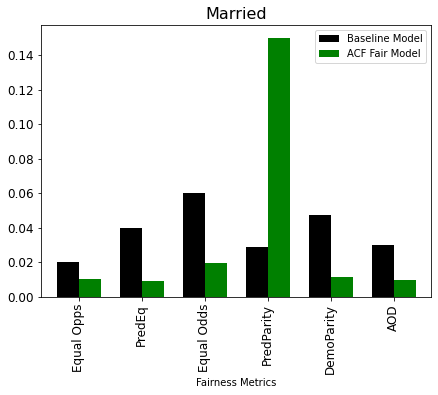

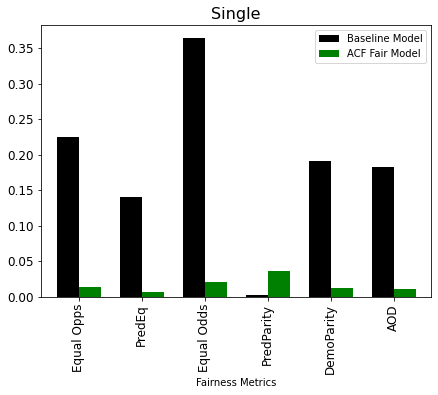

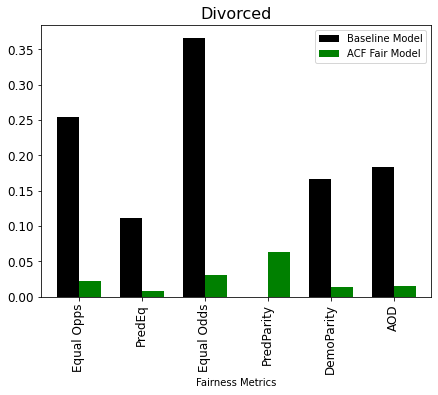

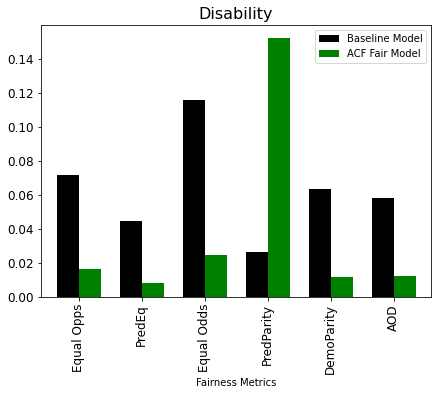

In [41]:
for groupe in range(0, len(biased_protected_groups)):
    choice = biased_protected_groups[groupe]
    protected_group = list(adv_groups[groupe].keys())[0]
    adv_protected_group_value = adv_groups[groupe][protected_group]
    disadv_protected_group_value = disadv_groups[groupe][protected_group]
    
    tn_disadv, fp_disadv, fn_disadv, tp_disadv = acf.confusion_mat(choice, disadv_protected_group_value)
    tn_adv, fp_adv, fn_adv, tp_adv = acf.confusion_mat(choice, adv_protected_group_value)
    
    acf_metrics = acf_fair_metrics(tn_disadv, fp_disadv, fn_disadv, tp_disadv, tn_adv, fp_adv, fn_adv, tp_adv)
    logistic_reg_fair_metrics = fair_metrics(y_test, y_pred_prob, y_pred, X_test, choice, adv_protected_group_value, disadv_protected_group_value)
    
    labels, log_reg_model = zip(*logistic_reg_fair_metrics)
    headers, acf_model = zip(*acf_metrics)
    ACF={'Fairness Metrics':headers[0:6], 
             'Baseline Model':list(log_reg_model[2:8]), 'ACF Fair Model':list(acf_model[0:6])}
    ACF_table=pd.DataFrame.from_dict(ACF) 
    
    ax = ACF_table.plot.bar(x='Fairness Metrics', rot=90, width = 0.7, color=['black', 'green'], figsize=(7,5), fontsize=12)
    plt.title(choice, fontsize=16)
plt.show()

## Model performance metrics 

In [42]:
model_perf=[accuracy_metrics(y_test, y_pred_prob, y_pred_prob_class, 
                          y_pred, y_pred_fair_class, X_test)]

headers=["AUC", "Gini", "Avg Precision Score", "Precision", "Sensitivity", "False Negative Rate", 
         "F1 Score"]

B = list(model_perf[0])[:len(list(model_perf[0]))//2]
C = list(model_perf[0])[len(list(model_perf[0]))//2:]


model_table={'Metrics':headers, 
             'Baseline':B, 'ACF':C}

model_table_df=pd.DataFrame.from_dict(model_table)
model_table_df

,Metrics,Baseline,ACF
0,AUC,0.311827,0.391476
1,Gini,-0.376346,-0.217047
2,Avg Precision Score,0.284200,0.241872
3,Precision,0.587977,0.657143
4,Sensitivity,0.139043,0.015950
5,False Negative Rate,0.860957,0.984050
6,F1 Score,0.224902,0.031144


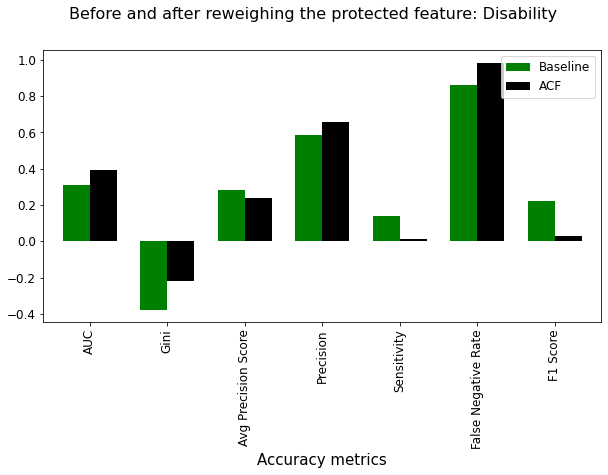

In [43]:
ax = model_table_df.iloc[:,:].plot.bar(x='Metrics', rot=90, width = 0.7, 
                                                       color=['green', 'black'], figsize=(10,5), fontsize=12)
plt.suptitle('Before and after reweighing the protected feature: {}'.format(choice),  fontsize=16, y=1)



patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper right', fontsize=12)

ax.set_xlabel('Accuracy metrics', fontsize=15)

plt.show()